# Using BERT and SQuaD for question answering

(based on https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT/ )

#### Please follow the instructions in this code and the workshop Instructor.

In the first part, please review the narrative and code to understand it, and run it.
Then, complete the tasks.


### How does the BERT transformer work?

To feed a QA task into BERT, we pack both the question and the reference text into the input.
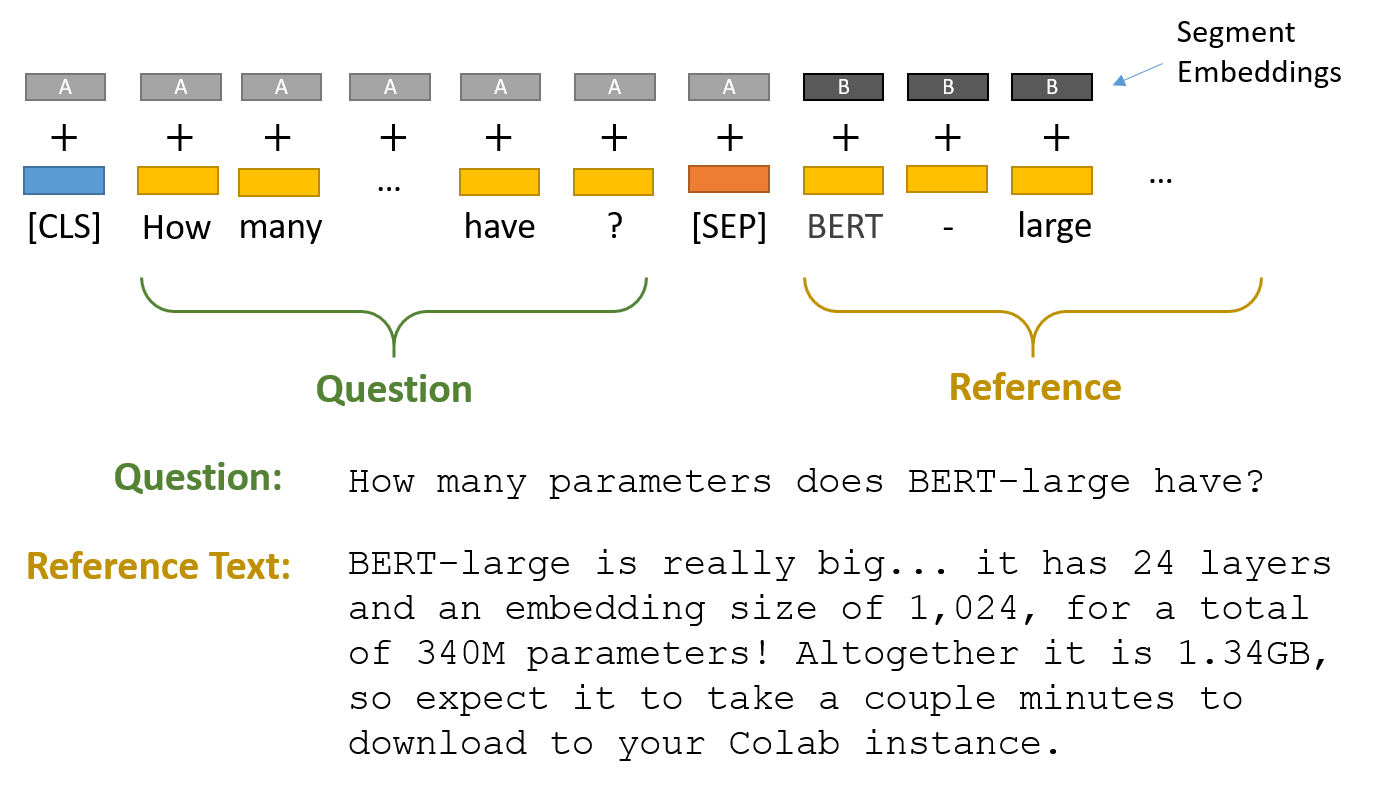

The two pieces of text are separated by the special [SEP] token.

BERT also uses “Segment Embeddings” to differentiate the question from the reference text. These are simply two embeddings (for segments “A” and “B”) that BERT learned, and which it adds to the token embeddings before feeding them into the input layer.

##### Start & End Token Classifiers

BERT needs to highlight a “span” of text containing the answer–this is represented as simply predicting which token marks the start of the answer, and which token marks the end.
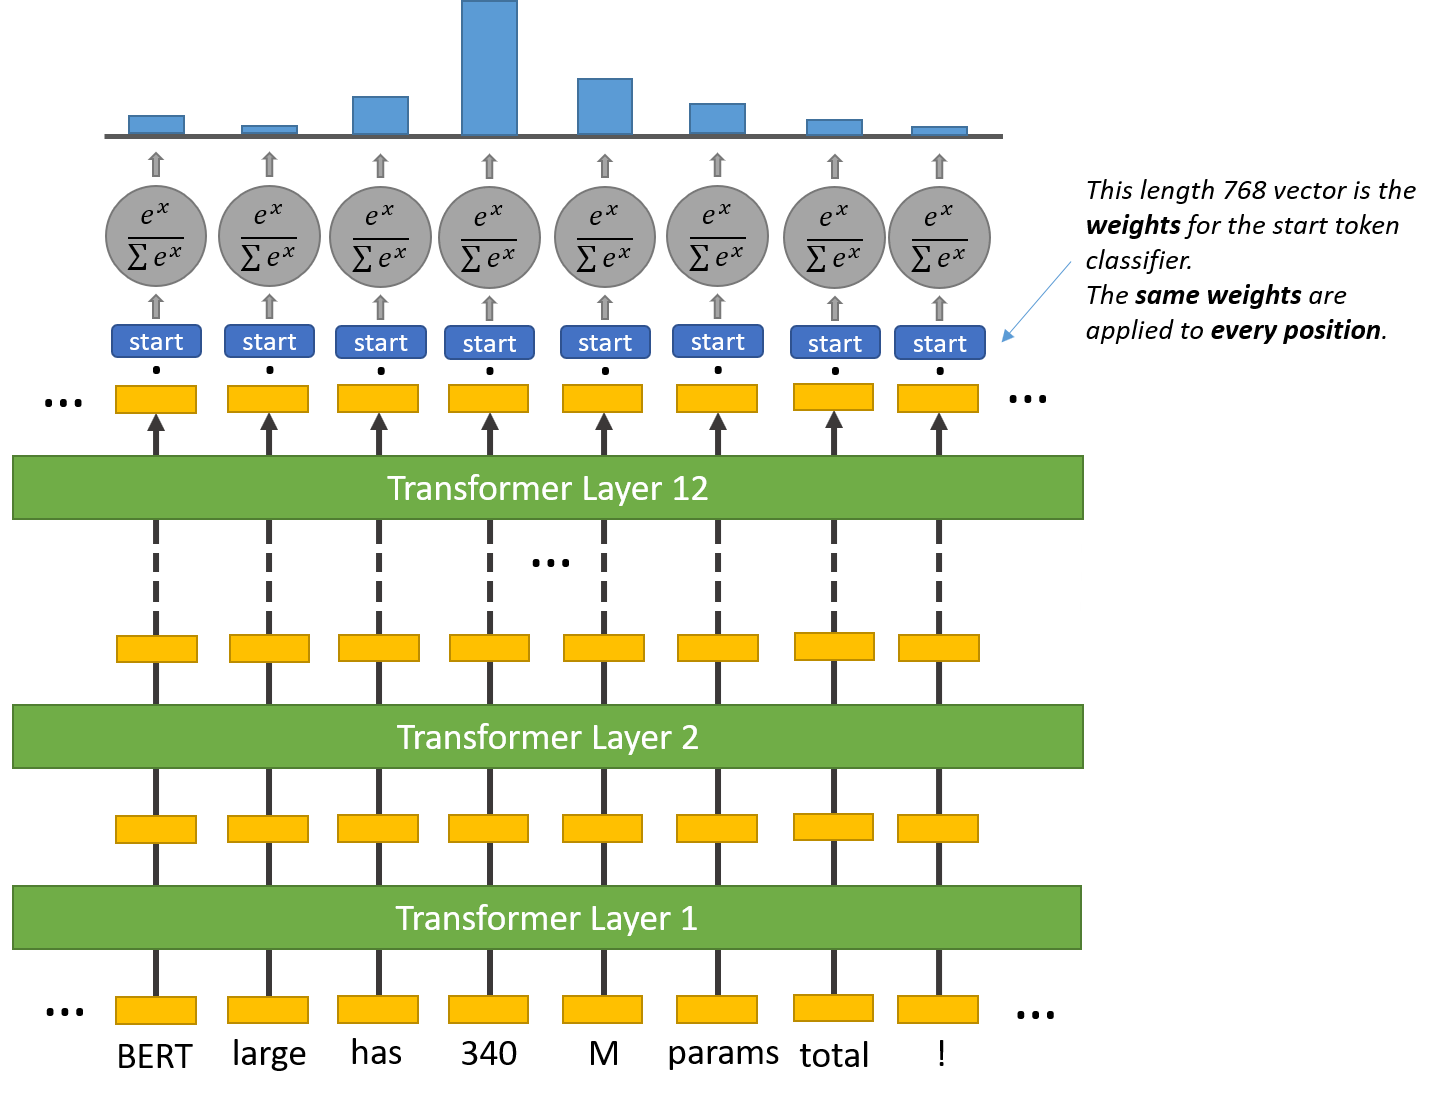
For every token in the text, we feed its final embedding into the start token classifier. The start token classifier only has a single set of weights (represented by the blue “start” rectangle in the above illustration) which it applies to every word.

After taking the dot product between the output embeddings and the ‘start’ weights, we apply the softmax activation to produce a probability distribution over all of the words. Whichever word has the highest probability of being the start token is the one that we pick.

We repeat this process for the end token–we have a separate weight vector this.
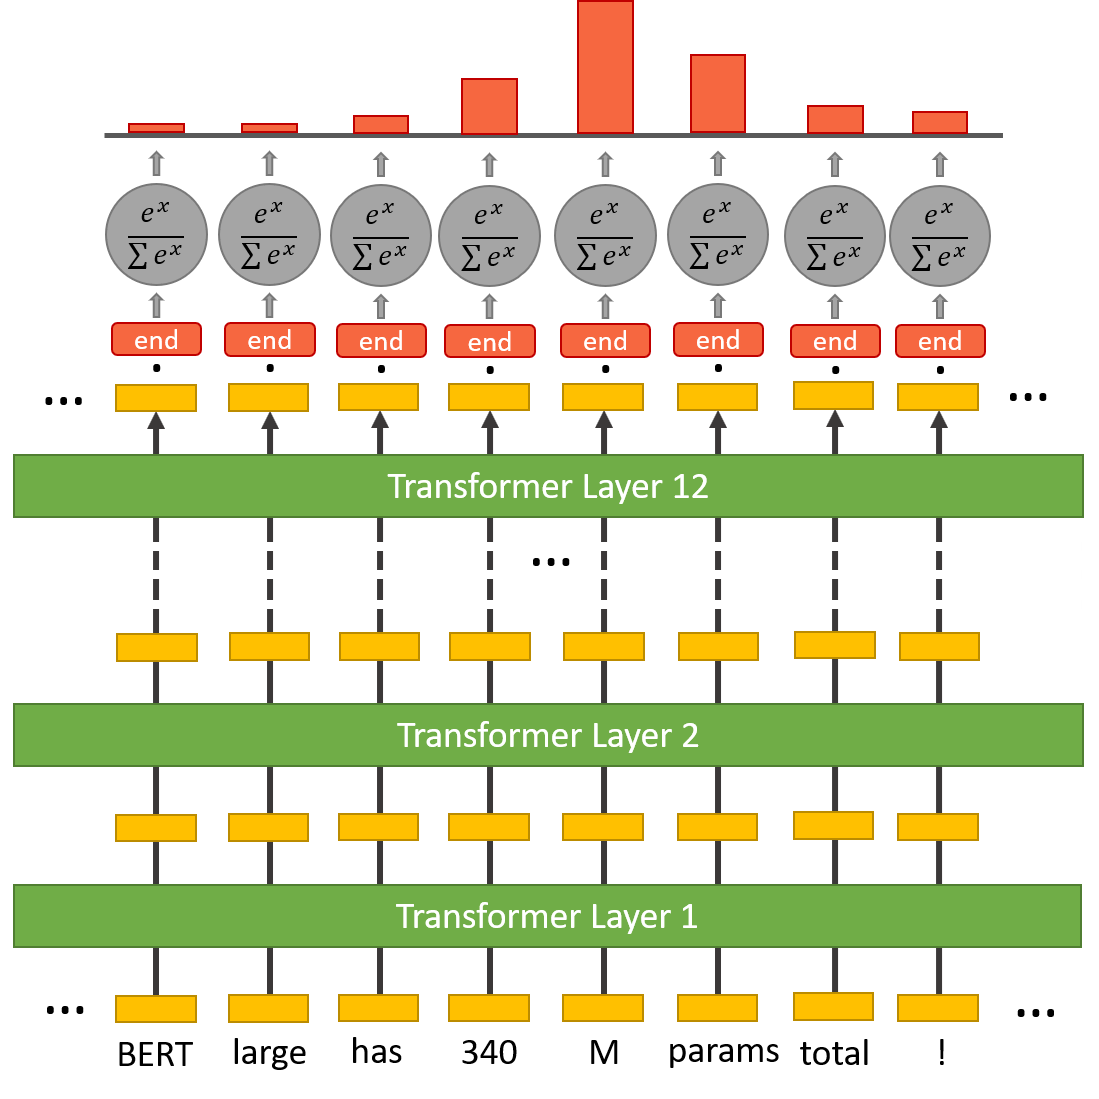



### Step 1. Install Transformers

In conda enter: pip install transformers

### Step 2. Download pre-trained BERT question answering transformer

This one is very big: 1.34G. You can keep reviewing the code while the package is being loaded.

In [1]:
import torch
from transformers import BertForQuestionAnswering, BertTokenizer
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

C:\Users\a1231060\AppData\Local\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\a1231060\AppData\Local\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


C:\Users\a1231060\AppData\Local\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\a1231060\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Step 3. Ask a question
A QA example consists of a question and a passage of text containing the answer to that question.

In [2]:
question = "How many parameters does BERT-large have?"
answer_text = "BERT-We’ll need to run the BERT tokenizer against both the question and the answer_text. To feed these into BERT, we actually concatenate them together and place the special [SEP] token in between.large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance."


We’ll need to run the BERT tokenizer against both the question and the answer_text. To feed these into BERT, we actually concatenate them together and place the special [SEP] token in between.

In [3]:
# Apply the tokenizer to the input text, treating them as a text-pair.
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 112 tokens.


Just to see exactly what the tokenizer is doing, let’s print out the tokens with their IDs.

In [4]:
# BERT only needs the token IDs, but for the purpose of inspecting the 
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')
    

[CLS]           101
how           2,129
many          2,116
parameters   11,709
does          2,515
bert         14,324
-             1,011
large         2,312
have          2,031
?             1,029

[SEP]           102

bert         14,324
-             1,011
we            2,057
’             1,521
ll            2,222
need          2,342
to            2,000
run           2,448
the           1,996
bert         14,324
token        19,204
##izer       17,629
against       2,114
both          2,119
the           1,996
question      3,160
and           1,998
the           1,996
answer        3,437
_             1,035
text          3,793
.             1,012
to            2,000
feed          5,438
these         2,122
into          2,046
bert         14,324
,             1,010
we            2,057
actually      2,941
con           9,530
##cate       16,280
##nate       12,556
them          2,068
together      2,362
and           1,998
place         2,173
the           1,996
special       2,56

We’ve concatenated the question and answer_text together, but BERT still needs a way to distinguish them. BERT has two special “Segment” embeddings, one for segment “A” and one for segment “B”. Before the word embeddings go into the BERT layers, the segment A embedding needs to be added to the question tokens, and the segment B embedding needs to be added to each of the answer_text tokens.

These additions are handled for us by the transformer library, and all we need to do is specify a ‘0’ or ‘1’ for each token.

In [5]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

We’re ready to feed our example into the model!

In [6]:
# Run our example through the model.
model_scores = model.forward(torch.tensor([input_ids]), # The tokens representing our input text.
                                 token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

start_scores = model_scores.start_logits
end_scores = model_scores.end_logits

Now we can highlight the answer just by looking at the most probable start and end words.

In [7]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "340 ##m"


### Visualizing scores of start and end words

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

Retrieve all of the start and end scores, and use all of the tokens as x-axis labels.

In [9]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

Create a bar plot showing the score for every input word being the “start” word.

C:\Users\a1231060\AppData\Local\Temp\ipykernel_14016\2520861439.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=token_labels, y=s_scores, ci=None)


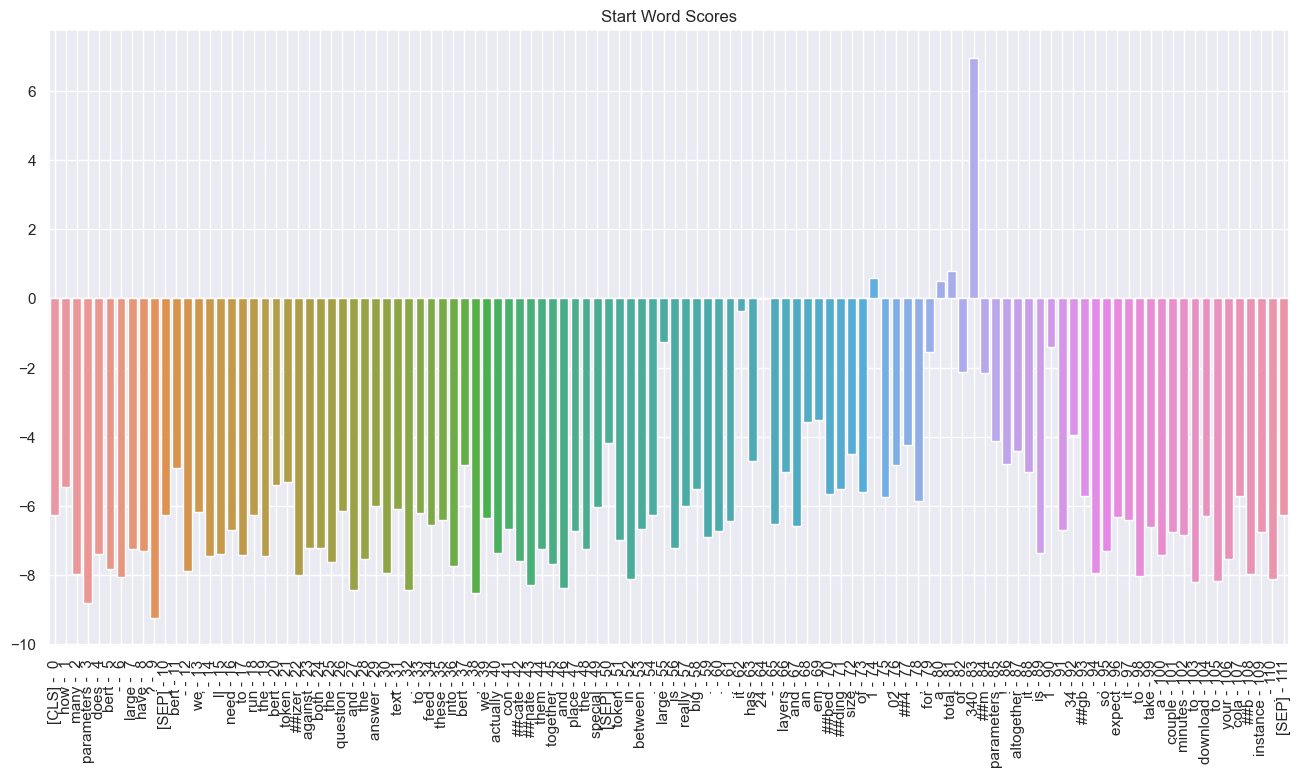

In [10]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

Create a second bar plot showing the score for every input word being the “end” word.

C:\Users\a1231060\AppData\Local\Temp\ipykernel_14016\645875075.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=token_labels, y=e_scores, ci=None)


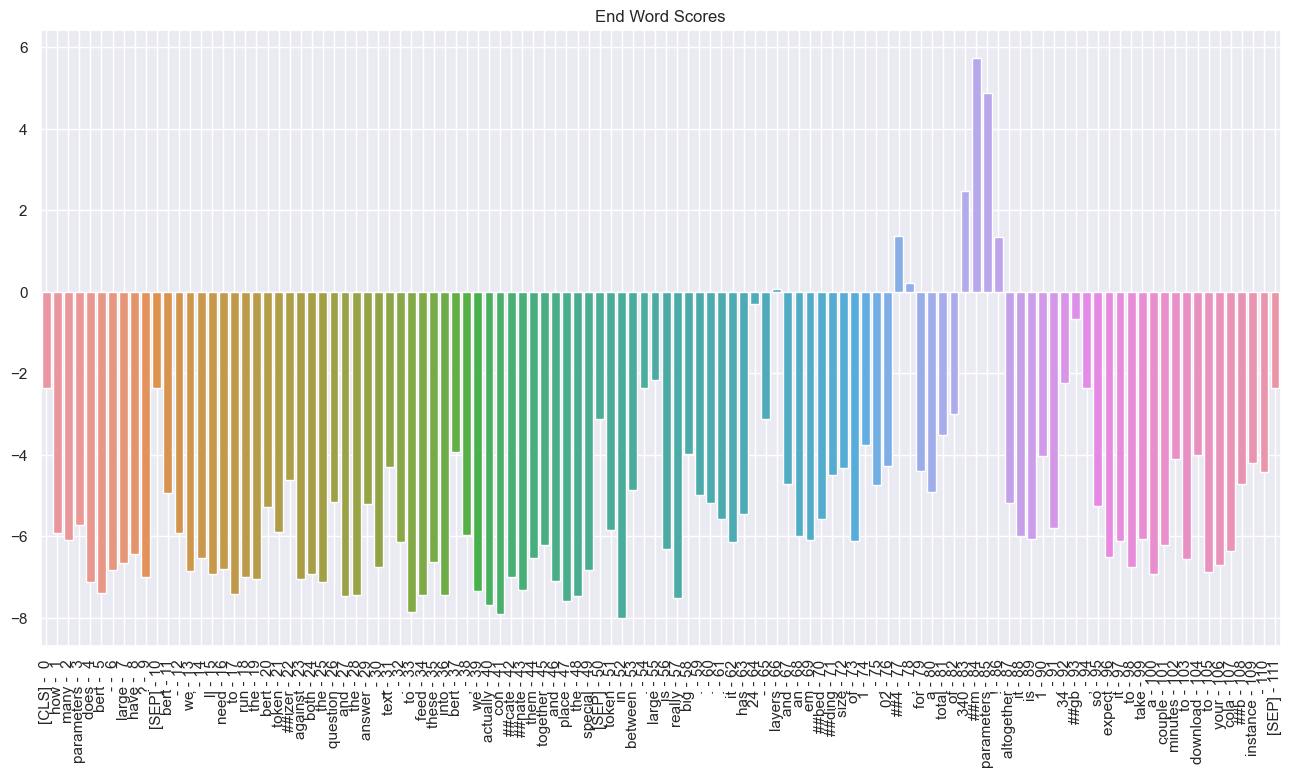

In [11]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

## Task 1: Create a complete function to ask more questions

Complete the below code and debug it with a sample question and answers (they can be above texts)

In [12]:
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the encode text, treating them as a question, answer_text pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example question through the model.
    model_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                    token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text
    start_scores = model_scores.start_logits
    end_scores = model_scores.end_logits
    
    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

Here are some more examples of question answering using the above function

In [13]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement)."

print(wrapper.fill(bert_abstract))


We introduce a new language representation model called BERT, which stands for
Bidirectional Encoder Representations from Transformers. Unlike recent language
representation models (Peters et al., 2018a; Radford et al., 2018), BERT is
designed to pretrain deep bidirectional representations from unlabeled text by
jointly conditioning on both left and right context in all layers. As a result,
the pre-trained BERT model can be finetuned with just one additional output
layer to create state-of-the-art models for a wide range of tasks, such as
question answering and language inference, without substantial taskspecific
architecture modifications. BERT is conceptually simple and empirically
powerful. It obtains new state-of-the-art results on eleven natural language
processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute
improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1
question answering Test F1 to 93.2 (1.5 point absolute improvement) 

In [14]:
question = "What does the 'B' in BERT stand for?"

answer_question(question, bert_abstract)

Query has 258 tokens.

Answer: "bidirectional encoder representations from transformers"


In [15]:
question = "What are some example applications of BERT?"

answer_question(question, bert_abstract)

Query has 255 tokens.

Answer: "question answering and language inference"


## Task 2: Ask your own questions from Assignment 2

Choose an article from Assignment 2, design a question (questions), answer(s) and run through the above code.

Note the performance and think how to improve the model.

#### For the workshop Instructor: Optional workshop questions

Here are somme optional questions that can be asked for the students to think about. However, the first priority is to complete the tasks that may help with the assignment.


1. Can you extend the BERT-SQuaD model to handle multilingual question-answering? Which language(s) would you choose to work with, and how would you fine-tune the BERT model to handle these languages?

2. How can you extend the BERT-SQuaD model to handle passage retrieval from a larger corpus of documents, rather than just a single passage? What challenges do you anticipate, and how would you address them?

3. How can you extend the BERT-SQuaD model to handle contextual question answering, such as within a conversation? What modifications would you need to make to the current implementation, and how would you evaluate the performance of the model?

4. How can you extend the BERT-SQuaD model to handle more complex types of questions, such as those that require reasoning or inference? Can you suggest some datasets or examples that would be suitable for testing such extensions?

5. Can you extend the BERT-SQuaD model to handle domain-specific question-answering, such as for medical or legal domains? How would you go about acquiring and fine-tuning the relevant domain-specific data?

6. Can you extend the BERT-SQuaD model to handle multi-hop question-answering, where the answer requires multiple pieces of information from different parts of the passage? What modifications would you need to make to the current implementation?

7. Can you extend the BERT-SQuaD model to handle sentiment analysis, in addition to question-answering? How would you modify the model to handle this task, and what datasets would be suitable for evaluation?